<a href="https://colab.research.google.com/github/imamfirdaus-if/PembelajaranMesin/blob/main/Pertemuan_12_Sentiment_Analysis_Case_Using_Simple_RNN_Single_LSTM_Bidirectional_LSTM_and_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis Case Using Simple RNN, Single LSTM, Bidirectional LSTM, and CNN 

## Dataset Importing

In [3]:
import pandas as pd
#Read standar data dari github 
train = pd.read_csv('https://raw.githubusercontent.com/WildanBudiawanZ/pembelajaran-mesin/main/twitter.csv', sep=',')

## Data Understanding

In [4]:
train.head(10)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive
7,50e14c0bb8,Soooo high,Soooo high,neutral
8,e050245fbd,Both of you,Both of you,neutral
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive


In [5]:
len(train)

27481

In [6]:
train['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [7]:
#Melihat distribusi dataset yang digunakan
train.groupby('sentiment').nunique()

,textID,text,selected_text
sentiment,,,
negative,7781,7781,5861
neutral,11118,11117,11111
positive,8582,8582,5537


## Data cleaning

In [8]:
#Mengambil kolom yang akan digunakan
train = train[['selected_text','sentiment']]
train.head()

,selected_text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD,negative
2,bullying me,negative
3,leave me alone,negative
4,"Sons of ****,",negative


In [10]:
#Cek data untuk null value
train["selected_text"].isnull().sum()

0

In [11]:
#Mengisi nilai null value
train["selected_text"].fillna("No content", inplace = True)

The next steps about data cleaning will be:
1. Remove URLs from the tweets
2. Tokenize text
3. Remove emails
4. Remove new lines characters
5. Remove distracting single quotes
6. Remove all punctuation signs
7. Lowercase all text
8. Detokenize text
9. Convert list of texts to Numpy array

In [12]:
import re

def depure_data(data):
    
    #Menghapus URL dengan ekspresi reguler
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    #Menghapus Email
    data = re.sub('\S*@\S*\s?', '', data)

    #Menghapus karakter
    data = re.sub('\s+', ' ', data)

    #Menghapus quotes 
    data = re.sub("\'", "", data)
        
    return data

In [13]:
temp = []
#Memisahkan pd.Series menjadi list
data_to_list = train['selected_text'].values.tolist()
for i in range(len(data_to_list)):
  temp.append(depure_data(data_to_list[i]))
list(temp[:50])

['I`d have responded, if I were going',
 'Sooo SAD',
 'bullying me',
 'leave me alone',
 'Sons of ****,',
 ' - some shameless plugging for the best Rangers forum on earth',
 'fun',
 'Soooo high',
 'Both of you',
 'Wow... u just became cooler.',
 'as much as i love to be hopeful, i reckon the chances are minimal =P i`m never gonna get my cake and stuff',
 'like',
 'DANGERously',
 'lost',
 'test test from the LG enV2',
 'Uh oh, I am sunburned',
 '*sigh*',
 'sick',
 'onna',
 'Hes just not that into you',
 'oh Marly, I`m so sorry!! I hope you find her soon!! <3 <3',
 'interesting.',
 'is cleaning the house for her family who is comming later today..',
 'gotta restart my computer .. I thought Win7 was supposed to put an end to the constant rebootiness',
 'SEe waT I Mean bOuT FoLL0w fRiiDaYs... It`S cALLed LoSe f0LloWeRs FridAy... smH',
 'the free fillin` app on my ipod is fun, im addicted',
 'I`m sorry.',
 '.no internet',
 'fun',
 'Power back up not working too',
 'Quite....heavenly',
 'hop

In [14]:
from gensim.utils import simple_preprocess
import gensim

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  #Fungsi untuk menghilangkan tanda baca
        

data_words = list(sent_to_words(temp))
print(data_words[:10])

[['have', 'responded', 'if', 'were', 'going'], ['sooo', 'sad'], ['bullying', 'me'], ['leave', 'me', 'alone'], ['sons', 'of'], ['some', 'shameless', 'plugging', 'for', 'the', 'best', 'rangers', 'forum', 'on', 'earth'], ['fun'], ['soooo', 'high'], ['both', 'of', 'you'], ['wow', 'just', 'became', 'cooler']]


In [15]:
len(data_words)

27481

In [16]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [17]:
from nltk.tokenize.treebank import TreebankWordDetokenizer

data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
print(data[:5])

['have responded if were going', 'sooo sad', 'bullying me', 'leave me alone', 'sons of']


In [18]:
import numpy as np

data = np.array(data)

## Label Encoding

In [19]:
import tensorflow as tf

labels = np.array(train['sentiment'])
y = []
for i in range(len(labels)):
    if labels[i] == 'neutral':
        y.append(0)
    if labels[i] == 'negative':
        y.append(1)
    if labels[i] == 'positive':
        y.append(2)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

In [20]:
len(labels)

27481

## Data sequencing and splitting

In [21]:
import keras
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
max_words = 5000
max_len = 200

In [22]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...   68  146   41]
 [   0    0    0 ...    0  397   65]
 [   0    0    0 ...    0    0   11]
 ...
 [   0    0    0 ...  372   10    3]
 [   0    0    0 ...   24  542    4]
 [   0    0    0 ... 2424  199  657]]


In [23]:
print(labels)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]


In [24]:
#Membagi Data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tweets,labels, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

20610 6871 20610 6871


## Model building


### SimpleRNN model

In [26]:
model0 = Sequential()
model0.add(layers.Embedding(max_words, 15))
model0.add(layers.SimpleRNN(15))
model0.add(layers.Dense(3,activation='softmax'))
model0.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint0 = ModelCheckpoint("best_model0.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model0.fit(X_train, y_train, epochs=5,validation_data=(X_test, y_test),callbacks=[checkpoint0])

Epoch 1/5
644/645 [============================>.] - ETA: 0s - loss: 0.7624 - accuracy: 0.6739
Epoch 1: val_accuracy improved from -inf to 0.73323, saving model to best_model0.hdf5
645/645 [==============================] - 24s 36ms/step - loss: 0.7624 - accuracy: 0.6739 - val_loss: 0.6523 - val_accuracy: 0.7332
Epoch 2/5
645/645 [==============================] - ETA: 0s - loss: 0.5346 - accuracy: 0.7922
Epoch 2: val_accuracy improved from 0.73323 to 0.80483, saving model to best_model0.hdf5
645/645 [==============================] - 24s 37ms/step - loss: 0.5346 - accuracy: 0.7922 - val_loss: 0.5156 - val_accuracy: 0.8048
Epoch 3/5
645/645 [==============================] - ETA: 0s - loss: 0.4774 - accuracy: 0.8156
Epoch 3: val_accuracy did not improve from 0.80483
645/645 [==============================] - 23s 36ms/step - loss: 0.4774 - accuracy: 0.8156 - val_loss: 0.5247 - val_accuracy: 0.7888
Epoch 4/5
644/645 [============================>.] - ETA: 0s - loss: 0.4398 - accuracy: 0.

### Single LSTM layer model

In [27]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20))
model1.add(layers.LSTM(15,dropout=0.5))
model1.add(layers.Dense(3,activation='softmax'))
model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=5,validation_data=(X_test, y_test),callbacks=[checkpoint1])

Epoch 1/5
645/645 [==============================] - ETA: 0s - loss: 0.8133 - accuracy: 0.6438
Epoch 1: val_accuracy improved from -inf to 0.73730, saving model to best_model1.hdf5
645/645 [==============================] - 48s 70ms/step - loss: 0.8133 - accuracy: 0.6438 - val_loss: 0.6646 - val_accuracy: 0.7373
Epoch 2/5
645/645 [==============================] - ETA: 0s - loss: 0.5918 - accuracy: 0.7664
Epoch 2: val_accuracy improved from 0.73730 to 0.77267, saving model to best_model1.hdf5
645/645 [==============================] - 45s 69ms/step - loss: 0.5918 - accuracy: 0.7664 - val_loss: 0.5502 - val_accuracy: 0.7727
Epoch 3/5
645/645 [==============================] - ETA: 0s - loss: 0.5126 - accuracy: 0.7987
Epoch 3: val_accuracy improved from 0.77267 to 0.77456, saving model to best_model1.hdf5
645/645 [==============================] - 44s 69ms/step - loss: 0.5126 - accuracy: 0.7987 - val_loss: 0.5435 - val_accuracy: 0.7746
Epoch 4/5
645/645 [==============================] -

### Bidirectional LTSM model

In [28]:
model2 = Sequential()

model2.add(layers.Embedding(max_words, 40, input_length=max_len))
model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model2.add(layers.Dense(3,activation='softmax'))
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model2.fit(X_train, y_train, epochs=5,validation_data=(X_test, y_test),callbacks=[checkpoint2])

Epoch 1/5
645/645 [==============================] - ETA: 0s - loss: 0.8024 - accuracy: 0.6414
Epoch 1: val_accuracy improved from -inf to 0.74167, saving model to best_model2.hdf5
645/645 [==============================] - 89s 131ms/step - loss: 0.8024 - accuracy: 0.6414 - val_loss: 0.6389 - val_accuracy: 0.7417
Epoch 2/5
645/645 [==============================] - ETA: 0s - loss: 0.5689 - accuracy: 0.7746
Epoch 2: val_accuracy improved from 0.74167 to 0.77281, saving model to best_model2.hdf5
645/645 [==============================] - 76s 118ms/step - loss: 0.5689 - accuracy: 0.7746 - val_loss: 0.5506 - val_accuracy: 0.7728
Epoch 3/5
645/645 [==============================] - ETA: 0s - loss: 0.5013 - accuracy: 0.8034
Epoch 3: val_accuracy improved from 0.77281 to 0.80556, saving model to best_model2.hdf5
645/645 [==============================] - 77s 119ms/step - loss: 0.5013 - accuracy: 0.8034 - val_loss: 0.5066 - val_accuracy: 0.8056
Epoch 4/5
645/645 [==============================

### 1D Convolutional model

In [29]:
from keras import regularizers
model3 = Sequential()
model3.add(layers.Embedding(max_words, 40, input_length=max_len))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.MaxPooling1D(5))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.GlobalMaxPooling1D())
model3.add(layers.Dense(3,activation='softmax'))
model3.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])

checkpoint3 = ModelCheckpoint("best_model3.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model3.fit(X_train, y_train, epochs=5,validation_data=(X_test, y_test),callbacks=[checkpoint3])

Epoch 1/5
645/645 [==============================] - 12s 17ms/step - loss: 1.0518 - acc: 0.5279 - val_loss: 0.8975 - val_acc: 0.6046
Epoch 2/5
645/645 [==============================] - 11s 16ms/step - loss: 0.8649 - acc: 0.6132 - val_loss: 0.8514 - val_acc: 0.6193
Epoch 3/5
645/645 [==============================] - 11s 17ms/step - loss: 0.8246 - acc: 0.6312 - val_loss: 0.8344 - val_acc: 0.6428
Epoch 4/5
645/645 [==============================] - 11s 16ms/step - loss: 0.7782 - acc: 0.6923 - val_loss: 0.8232 - val_acc: 0.6241
Epoch 5/5
645/645 [==============================] - 11s 17ms/step - loss: 0.6871 - acc: 0.7664 - val_loss: 0.6909 - val_acc: 0.7459


## Best model validation

In [30]:
best_model = keras.models.load_model("best_model2.hdf5")

In [31]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

215/215 - 5s - loss: 0.4704 - accuracy: 0.8163 - 5s/epoch - 23ms/step
Model accuracy:  0.8163294792175293


In [32]:
predictions = best_model.predict(X_test)
predictions

array([[0.00921435, 0.01421522, 0.9765704 ],
       [0.02544538, 0.9674827 , 0.00707193],
       [0.36227623, 0.01249206, 0.6252316 ],
       ...,
       [0.02148328, 0.9670182 , 0.0114986 ],
       [0.9398809 , 0.03699575, 0.02312334],
       [0.44974118, 0.5352074 , 0.01505142]], dtype=float32)

## Confusion matrix

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.


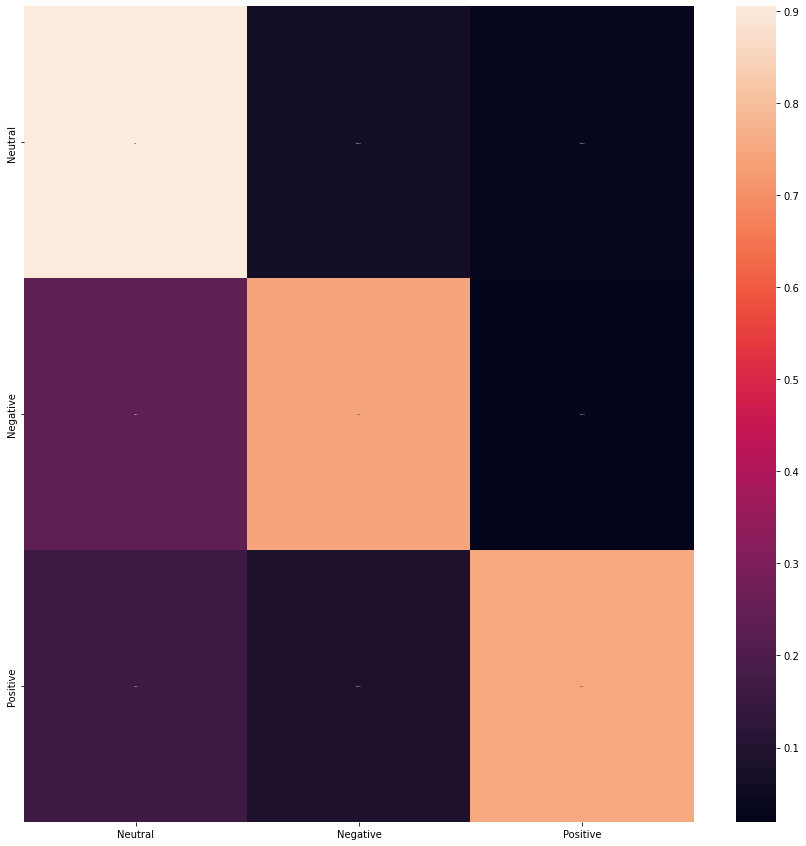

In [34]:
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalisasi
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 2})

In [35]:
sentiment = ['Neutral','Negative','Positive']

In [36]:
sentiment

['Neutral', 'Negative', 'Positive']

In [37]:
sentiment[2]

'Positive'

In [40]:
sequence = tokenizer.texts_to_sequences(['this experience has been the worst , want my money back'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'Neutral'

In [41]:
sequence = tokenizer.texts_to_sequences(['this data science article is the best ever'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'Positive'

In [43]:
sequence = tokenizer.texts_to_sequences(['i hate youtube ads, they are annoying'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'Negative'

# References:
https://github.com/WildanBudiawanZ/pembelajaran-mesin/blob/main/Pertemuan_12.ipynb